**Global sensitivity analysis, taking into account input dependencies**

**Ishigami model**

We define $Y=f(X)=\sin (X_1)+7 \, \sin^2(X_2)+0.1 \, X_3^4$.

In [1]:
ishigami <- function (X){ # Ishigami function
X<-X*2*pi-pi #transformto[-pi,pi]^3
sin(X[, 1]) + 7 * sin(X[, 2])^2 + 0.1 * X[, 3]^4 * sin(X[, 1])}

Sensitivity analysis for independent inputs, with $X \sim \mathcal{U}\left([-\pi,\pi]^3\right)$:

Loading required package: ggplot2


Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout


Registered S3 method overwritten by 'sensitivity':
  method    from 
  print.src dplyr



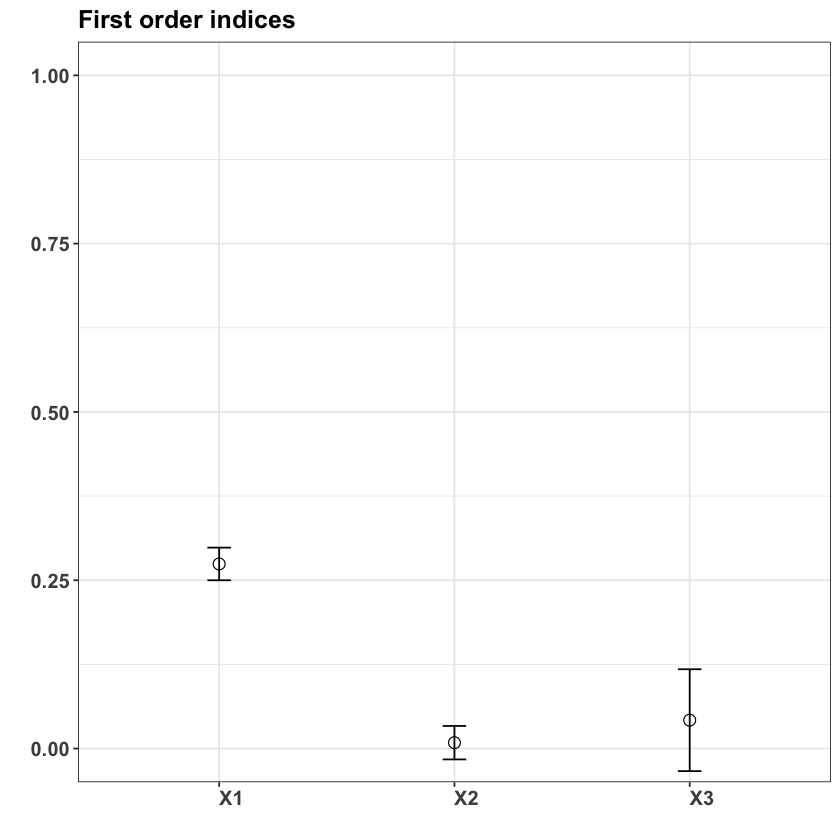

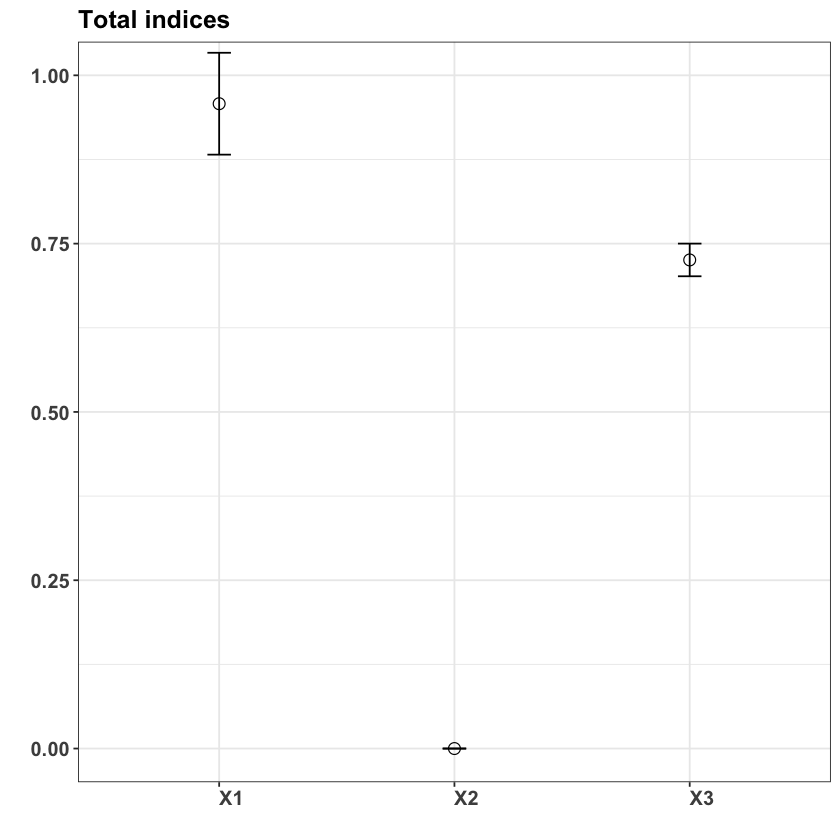

In [2]:
library(plotly)
library(reshape2)
library(sensitivity)
library(boot)
library(numbers)

nGSA <- 5000

generate.GSA.sample.QMC <- function(nsample){
  sample <- randtoolbox::sobol(nsample,6) 
  return(sample)
}

s <- generate.GSA.sample.QMC(nGSA)
X1 <- 2*pi*s[,1:3]-pi
X2 <- 2* pi * s[,4:6]-pi



######## first order ##############
xx <- sobolEff(model = NULL, X1, X2,order=1,conf=0.95)
yy <- ishigami(xx$X)

ss.time.maxR <- tell(xx,y=yy[,drop=FALSE])
ggplot(ss.time.maxR)


############# total #################
xxt <- sobolEff(model = NULL, X1, X2,order=0, conf=0.95)
yyt <- ishigami(xxt$X)

ss.time.maxR <- tell(xxt,y=yyt[,drop=FALSE])
ggplot(ss.time.maxR)

Warning message in sobolroalhs(model = NULL, factors = 3, N = 5000, order = 2, nboot = 100):
“The value entered for N is not the square of a prime number. It has been replaced by: 4489”


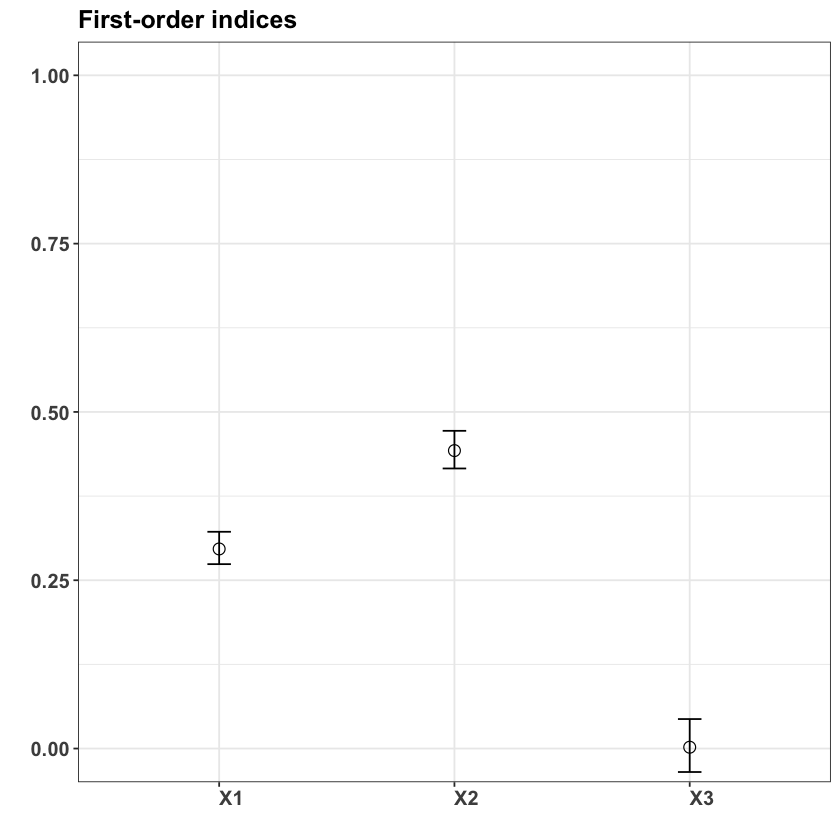

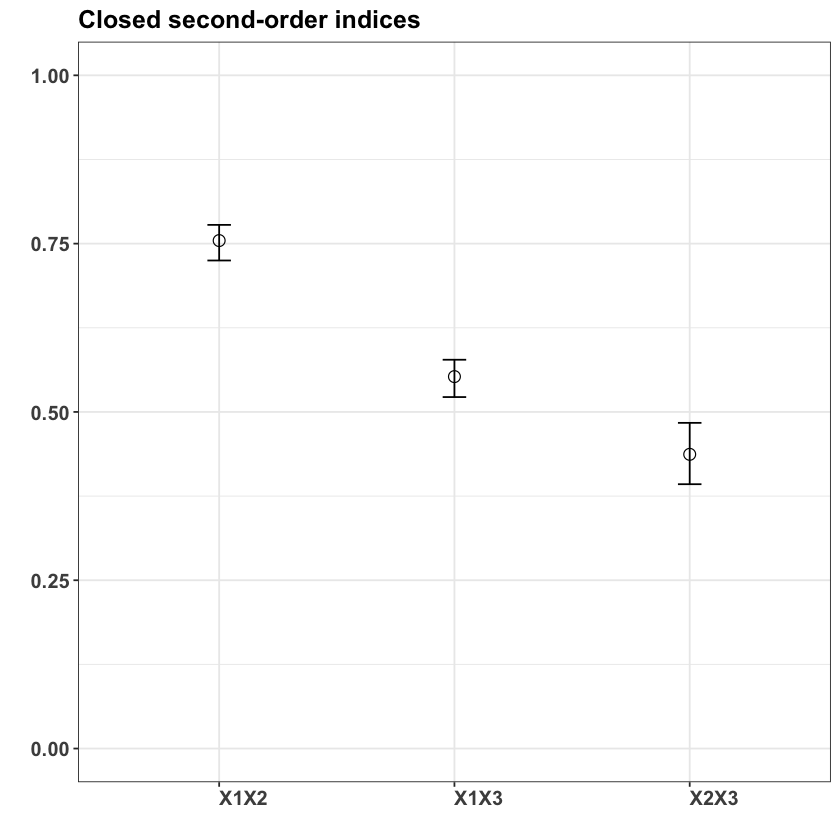

In [3]:
############# first and second order replicated designs #################
xxrep1 <- sobolroalhs(model = NULL, factors = 3, N = 5000, order = 1, nboot=100)
yyrep1 <- ishigami(xxrep1$X)

ss.time.maxR <- tell(xxrep1,y=yyrep1[,drop=FALSE])
ggplot(ss.time.maxR)

xxrep2 <- sobolroalhs(model = NULL, factors = 3, N = 5000, order = 2, nboot=100)
yyrep2 <- ishigami(xxrep2$X)

ss.time.maxR <- tell(xxrep2,y=yyrep2[,drop=FALSE])
ggplot(ss.time.maxR)

Let us assume now that inputs are dependent, with Gaussian copula.

In [4]:
# Simulation function for U[0,1] variables (with Gaussian copula) 
install.packages("copula")
library(copula)
Xall <- function(n) rCopula(n, norm.cop)
ro <- 0.9 # Correlation coefficient (between X1 and X3)
Cormat <- matrix(c(1,0,ro,0,1,0,ro,0,1),3,3) # Correlation matrix 
norm.cop <- normalCopula(c(0,ro,0), dim = 3, dispstr = "un")


The downloaded binary packages are in
	/var/folders/wn/p_gs3z3j00b8whbmffbzr8g00000gn/T//RtmpG4wVg2/downloaded_packages



Attaching package: ‘copula’


The following object is masked from ‘package:numbers’:

    tau




In [5]:
set.seed(12345) # To reproduce the same results
n <- 5000
X1 <- data.frame(Xall(n)) ; X2 <- data.frame(Xall(n))
sa <- sobol(ishigami,X1=X1,X2=X2,order=list(c(1,3),2),nboot=100)
print(sa$V[-1,]/sa$V[1,1]) # Divide by variance to get Sobol'

       original          bias std. error min. c.i. max. c.i.
X1*X3 0.4147371 -0.0008850196 0.02243669 0.3678496 0.4543513
X2    0.5872457 -0.0032157085 0.01966698 0.5555492 0.6281206


In [6]:
install.packages("gtools")
library(gtools)
d <- 3
Xset <- function(n, Sj, Sjc, xjc){ 
nj <- length(Sj) ; njc <- length(Sjc) 
if (is.null(Sjc)){ 
if (nj==1){runif(n)} else{ 
Cormat2 <- Cormat[Sj,Sj]
a2 <- combinations(nj, 2, 1:nj)
corp2 <- Cormat2[matrix(a2[1:dim(a2)[[1]],],nr=dim(a2)[[1]])] 
norm2.cop <- normalCopula(corp2, dim = nj, dispstr = "un")
rCopula(n,norm2.cop) 
}
} else{
xx <- cbind(matrix(xjc,nc=njc,nr=n,byrow=T), matrix(runif(n*nj),nc=nj))
cc <- c(Sjc,Sj) ; a2 <- NULL 
for (i in 1:(d-1)) for (j in (i+1):d) a2 <- rbind(a2,c(cc[i],cc[j])) 
corp2 <- Cormat[matrix(a2[1:dim(a2)[[1]],], nr=dim(a2)[[1]])] 
norm2.cop <- copula::normalCopula(corp2, dim = d, dispstr = "un") 
x <- cCopula(xx, copula = norm2.cop, inverse = TRUE) 
x[,((njc+1):(njc+nj))]
}}


The downloaded binary packages are in
	/var/folders/wn/p_gs3z3j00b8whbmffbzr8g00000gn/T//RtmpG4wVg2/downloaded_packages



Attaching package: ‘gtools’


The following objects are masked from ‘package:boot’:

    inv.logit, logit


The following object is masked from ‘package:sensitivity’:

    ask





Call:
shapleyPermRand(model = ishigami, Xall = Xall, Xset = Xset, d = 3,     Nv = 5000, m = 1000, No = 1, Ni = 3)

Model runs: 11000 

Shapley' effects:
    original std. error min. c.i. max. c.i.
X1 0.2021376 0.01686196 0.1684136 0.2358615
X2 0.5974270 0.01739389 0.5626392 0.6322148
X3 0.2004355 0.01648204 0.1674714 0.2333995

Full first order Sobol' indices:
    original std. error min. c.i. max. c.i.
X1 0.2668751 0.03398456 0.2002653 0.3334848
X2 0.5725083 0.02594449 0.5216571 0.6233595
X3 0.3000312 0.03284869 0.2356477 0.3644146

Independent total Sobol' indices:
    original  std. error  min. c.i. max. c.i.
X1 0.1190566 0.012407068 0.09473873 0.1433744
X2 0.5828222 0.023083856 0.53757785 0.6280666
X3 0.1045405 0.009522591 0.08587626 0.1232048


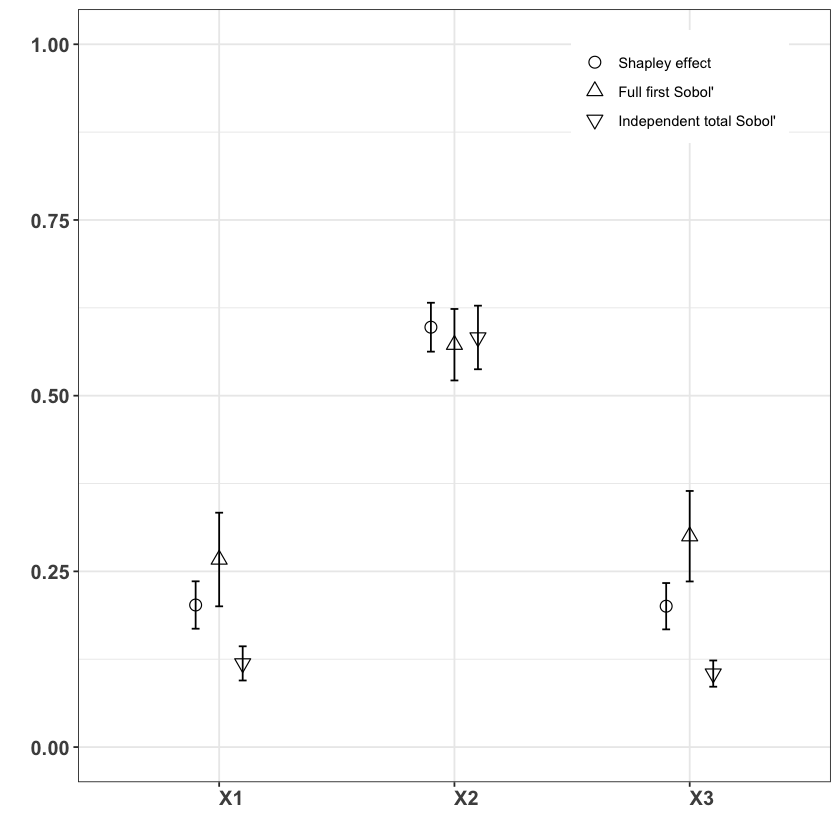

In [7]:
sa <- shapleyPermRand(ishigami,Xall,Xset,d=3,Nv=5000,No=1,Ni=3,m=1000)
print(sa)
ggplot(sa)